Welcome to my Data Science exploration of projecting player point for the 2025 NFL SEASON
by Roberto Echeverria Sosa

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
import pandas as pd

df = pd.read_csv("/Users/robertoecheverria/player_weekly_last3seasons.csv")

'''print(df.shape)        # rows, columns
print(df.head())       # first 5 rows
print(df.dtypes)       # column types
print(df.isna().sum()) # missing values check
'''
# Number of rows
print("Number of rows:", len(df))

# Number of rows and columns 
print("The data has this many rows and columns.")
print("Shape:", df.shape)

Number of rows: 16136
The data has this many rows and columns.
Shape: (16136, 31)


We will use 2024 as test data, and 2022,2023 as our training data.

In [4]:
train = df[df['season'] < 2024]   # use 2022–2023
test  = df[df['season'] == 2024]  # validate on 2024


Model by position: Wide Receiver

In [5]:
## Here are key weights we can use:
print(df.columns.tolist())

['season', 'week', 'season_type', 'player_id', 'display_name', 'position', 'team', 'opponent_team', 'fantasy_points_ppr', 'fantasy_points', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'carries', 'rushing_yards', 'rushing_tds', 'targets', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_yards_after_catch', 'receiving_air_yards', 'passing_air_yards', 'passing_yards_after_catch', 'rushing_fumbles', 'rushing_fumbles_lost', 'receiving_fumbles', 'receiving_fumbles_lost', 'special_teams_tds']


In [6]:
# 2. Focus on WRs
wr_df = df[df["position"] == "WR"].copy()

# 3. Train/test split by season
train = wr_df[wr_df["season"].isin([2022, 2023])]
test  = wr_df[wr_df["season"] == 2024]

# 4. Pick WR features you decided on
wr_features = [
    "targets", "receptions", "receiving_yards", "receiving_tds",
    "receiving_air_yards", "receiving_yards_after_catch","completions",
    'receiving_fumbles'
]

X_train = train[wr_features].fillna(0)
y_train = train["fantasy_points_ppr"]

X_test = test[wr_features].fillna(0)
y_test = test["fantasy_points_ppr"]

# 5. Train a model
model = GradientBoostingRegressor(n_estimators=300, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 6. Evaluate on 2024
preds = model.predict(X_test)
print("WR model MAE:", mean_absolute_error(y_test, preds))

# 7. Add predictions back to test set
test["predicted_points"] = preds

# 8. Aggregate to season totals
season_preds = (
    test.groupby("display_name")[["fantasy_points_ppr","predicted_points"]]
        .sum()
        .sort_values("predicted_points", ascending=False)
        .reset_index()
)

print(season_preds.head(10))  # top 10 WRs by projected points


WR model MAE: 0.5167183918630195
         display_name  fantasy_points_ppr  predicted_points
0       Ja'Marr Chase              403.00        399.513577
1    Justin Jefferson              317.48        321.253207
2   Amon-Ra St. Brown              316.18        320.794478
3        Drake London              280.80        285.455383
4    Brian Thomas Jr.              284.00        277.912389
5        Malik Nabers              273.60        272.199966
6      Terry McLaurin              267.80        272.084483
7         CeeDee Lamb              263.40        260.981528
8  Jaxon Smith-Njigba              253.00        254.685402
9      Garrett Wilson              251.90        254.177861


/var/folders/h7/6g1958152171jbw1nmxq4j780000gn/T/ipykernel_21377/2264643692.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_points"] = preds


This model worked really well having a little more than half a point per week error.

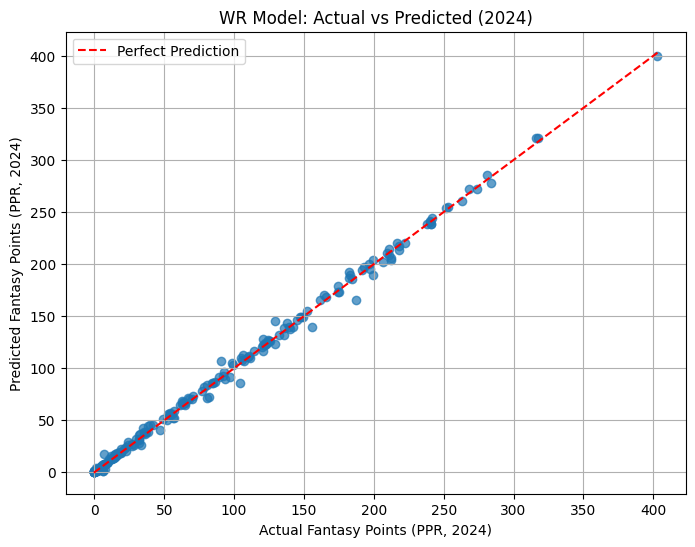

In [7]:
import matplotlib.pyplot as plt

# Scatterplot of actual vs predicted totals
plt.figure(figsize=(8,6))
plt.scatter(season_preds["fantasy_points_ppr"], season_preds["predicted_points"], alpha=0.7)

# Add a reference diagonal (perfect prediction line)
lims = [
    min(season_preds["fantasy_points_ppr"].min(), season_preds["predicted_points"].min()),
    max(season_preds["fantasy_points_ppr"].max(), season_preds["predicted_points"].max())
]
plt.plot(lims, lims, 'r--', label="Perfect Prediction")

plt.xlabel("Actual Fantasy Points (PPR, 2024)")
plt.ylabel("Predicted Fantasy Points (PPR, 2024)")
plt.title("WR Model: Actual vs Predicted (2024)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# features you used for WRs

TARGET_COL = "fantasy_points_ppr"

# --- Train on 2023-2024 WEEKLY WR data (per-week target) ---
train_wr = wr_df[wr_df["season"].isin([2023, 2024])].copy()
X_train = train_wr[wr_features].fillna(0)
y_train = train_wr[TARGET_COL].fillna(0)
model.fit(X_train, y_train)

# --- Build 2024 per-game inputs for each WR ---
wr_2024_weekly = wr_df[(wr_df["season"] == 2024)].copy()
wr_2024_weekly["games_played"] = 1  # each weekly row = one game

# aggregate sums + games per player
agg = wr_2024_weekly.groupby(["player_id","display_name"], as_index=False).agg(
    {**{f:"sum" for f in wr_features}, **{"games_played":"sum"}}
)

# convert to per-game features (what the model expects)
for f in wr_features:
    agg[f] = agg[f] / agg["games_played"].replace(0, 1)

# predict per-week, then scale up by expected games
expected_games_2025 = 17  # you can customize per player/team later
agg["predicted_points_per_week_2025"] = model.predict(agg[wr_features].fillna(0))
agg["predicted_points_2025"] = agg["predicted_points_per_week_2025"] * expected_games_2025

wr_2025_preds = (
    agg[["display_name","predicted_points_2025"]]
      .sort_values("predicted_points_2025", ascending=False)
      .reset_index(drop=True)
)

print("Top 10 WR 2025 projections (per-week model scaled to season):")
print(wr_2025_preds.head(30).to_string(index=False))


Top 10 WR 2025 projections (per-week model scaled to season):
         display_name  predicted_points_2025
          Rashee Rice             398.231818
        Ja'Marr Chase             396.522238
     Chris Godwin Jr.             369.962638
     Justin Jefferson             361.153546
    Amon-Ra St. Brown             345.910872
         Nico Collins             345.349502
        Davante Adams             335.139590
          Tee Higgins             334.694016
         Drake London             332.621590
           A.J. Brown             330.831270
           Mike Evans             316.620231
     Brian Thomas Jr.             313.323443
       Terry McLaurin             301.850771
        DeVonta Smith             296.608121
           Puka Nacua             277.550815
       Jordan Addison             270.087360
          CeeDee Lamb             261.076452
         Malik Nabers             261.060021
     Quentin Johnston             254.378180
       Tyrell Shavers             236.

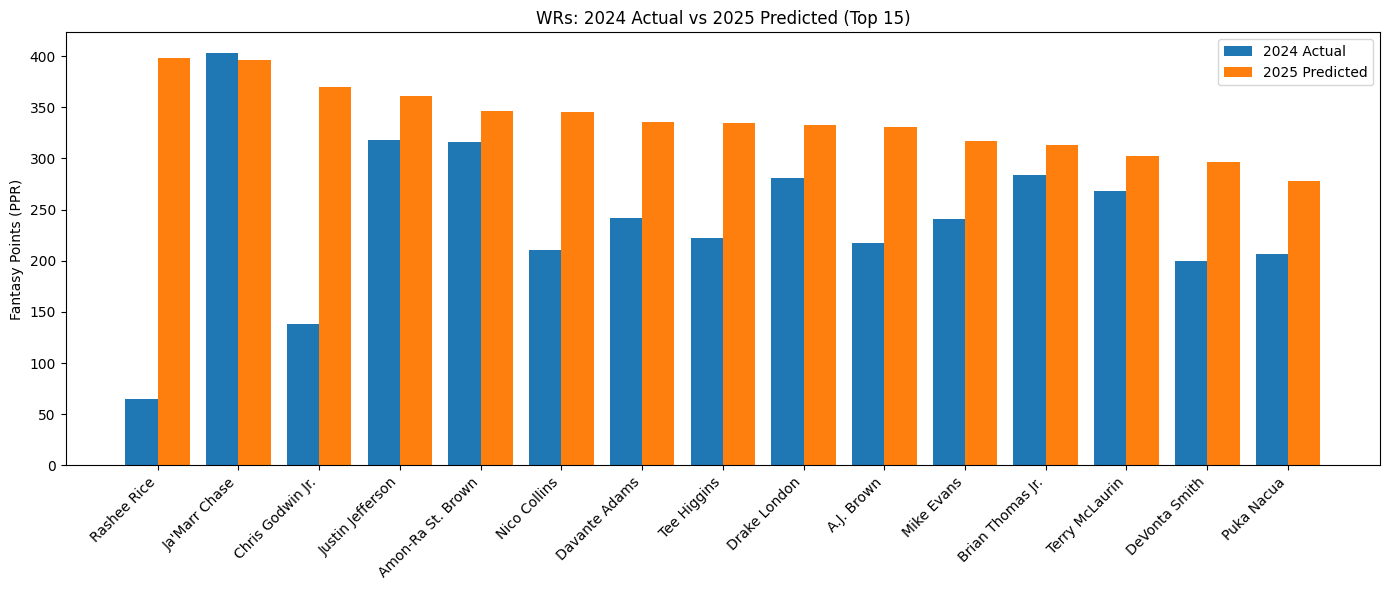

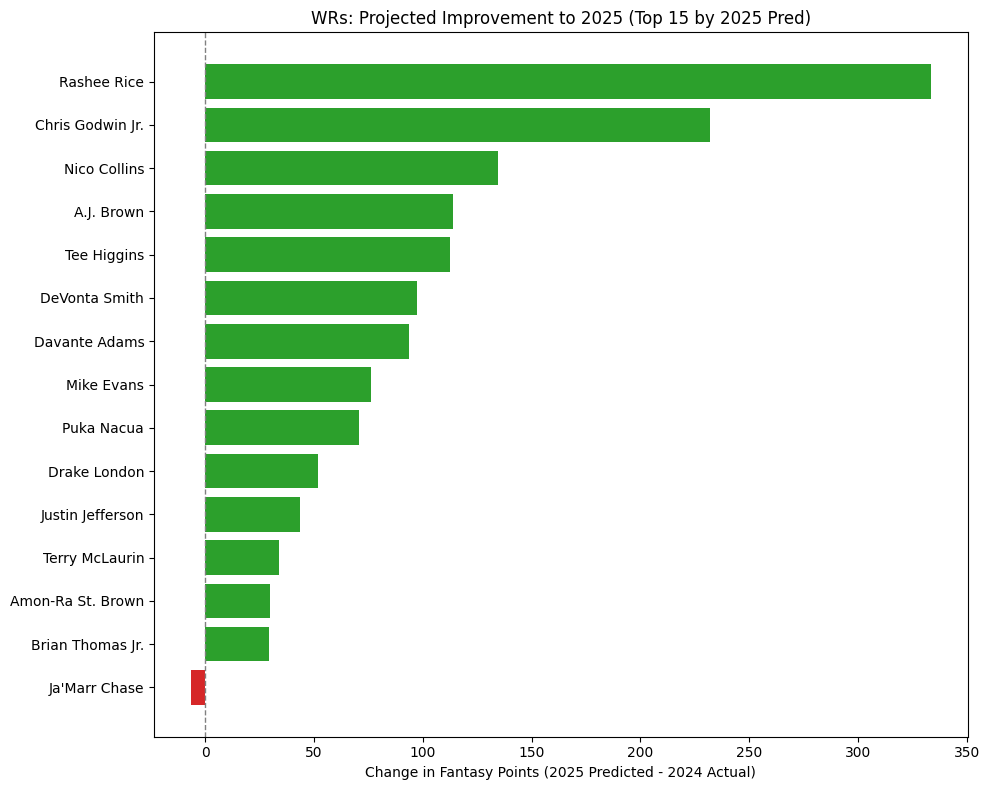

         display_name  actual_points_2024  predicted_points_2025       delta
0         Rashee Rice               64.90             398.231818  333.331818
1       Ja'Marr Chase              403.00             396.522238   -6.477762
2    Chris Godwin Jr.              137.80             369.962638  232.162638
3    Justin Jefferson              317.48             361.153546   43.673546
4   Amon-Ra St. Brown              316.18             345.910872   29.730872
5        Nico Collins              210.60             345.349502  134.749502
6       Davante Adams              241.30             335.139590   93.839590
7         Tee Higgins              222.10             334.694016  112.594016
8        Drake London              280.80             332.621590   51.821590
9          A.J. Brown              216.90             330.831270  113.931270
10         Mike Evans              240.40             316.620231   76.220231
11   Brian Thomas Jr.              284.00             313.323443   29.323443

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_wr_2024_vs_2025(wr_weekly_df: pd.DataFrame,
                            wr_2025_preds: pd.DataFrame,
                            top_n: int = 15):
    """
    wr_weekly_df: weekly WR rows with columns at least
        ['season', 'player_id', 'display_name', 'fantasy_points_ppr']
    wr_2025_preds: predictions with columns:
        ['display_name', 'predicted_points_2025']  (and optionally 'player_id')
    top_n: how many WRs to visualize (default 15)

    Returns the DataFrame used for plotting.
    """

    # --- Actual 2024 totals (per WR) ---
    actual_2024 = (
        wr_weekly_df[wr_weekly_df["season"] == 2024]
        .groupby(["player_id", "display_name"], as_index=False)["fantasy_points_ppr"]
        .sum()
        .rename(columns={"fantasy_points_ppr": "actual_points_2024"})
    )

    # --- Merge with 2025 predictions ---
    # Prefer merging on player_id + name if available
    if "player_id" in wr_2025_preds.columns:
        on_cols = ["player_id", "display_name"]
    else:
        on_cols = ["display_name"]

    compare = actual_2024.merge(
        wr_2025_preds,
        on=on_cols,
        how="inner"
    )

    # Compute delta (improvement)
    compare["delta"] = compare["predicted_points_2025"] - compare["actual_points_2024"]

    # Pick top N by predicted 2025
    topN = (
        compare.sort_values("predicted_points_2025", ascending=False)
               .head(top_n)
               .reset_index(drop=True)
    )

    # --- Plot 1: side-by-side bars (2024 vs 2025) ---
    x = range(len(topN))
    plt.figure(figsize=(14, 6))
    plt.bar(x, topN["actual_points_2024"], width=0.4, label="2024 Actual", align="center")
    plt.bar([i + 0.4 for i in x], topN["predicted_points_2025"], width=0.4, label="2025 Predicted", align="center")
    plt.xticks([i + 0.2 for i in x], topN["display_name"], rotation=45, ha="right")
    plt.ylabel("Fantasy Points (PPR)")
    plt.title(f"WRs: 2024 Actual vs 2025 Predicted (Top {top_n})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: improvement (delta) ---
    topN_delta = topN.sort_values("delta", ascending=True)  # for a nice upward barh
    plt.figure(figsize=(10, 8))
    colors = ["#2ca02c" if d > 0 else "#d62728" for d in topN_delta["delta"]]
    plt.barh(topN_delta["display_name"], topN_delta["delta"], color=colors)
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Change in Fantasy Points (2025 Predicted - 2024 Actual)")
    plt.title(f"WRs: Projected Improvement to 2025 (Top {top_n} by 2025 Pred)")
    plt.tight_layout()
    plt.show()

    return topN

# ---- How to call (example) ----
wr_df = df[df["position"] == "WR"].copy()  # your weekly WR dataframe
top15 = compare_wr_2024_vs_2025(wr_df, wr_2025_preds, top_n=15)
print(top15[["display_name", "actual_points_2024", "predicted_points_2025", "delta"]])


In [10]:
from tabulate import tabulate

# pick the columns you care about
cols = ["display_name", "position","week",'fantasy_points', "receiving_tds", "receptions"]

# sort by predicted points, highest first
top5_wr = (
    wr_df.sort_values('fantasy_points', ascending=False)
         .head(5)[cols]
)

# print nicely
print(tabulate(top5_wr, headers="keys", tablefmt="fancy_grid"))


╒═══════╤════════════════╤════════════╤════════╤══════════════════╤═════════════════╤══════════════╕
│       │ display_name   │ position   │   week │   fantasy_points │   receiving_tds │   receptions │
╞═══════╪════════════════╪════════════╪════════╪══════════════════╪═════════════════╪══════════════╡
│ 13600 │ Ja'Marr Chase  │ WR         │     10 │             44.4 │               3 │           11 │
├───────┼────────────────┼────────────┼────────┼──────────────────┼─────────────────┼──────────────┤
│  6714 │ DJ Moore       │ WR         │      5 │             41   │               3 │            8 │
├───────┼────────────────┼────────────┼────────┼──────────────────┼─────────────────┼──────────────┤
│  9857 │ Amari Cooper   │ WR         │     16 │             40.5 │               2 │           11 │
├───────┼────────────────┼────────────┼────────┼──────────────────┼─────────────────┼──────────────┤
│  4974 │ Mike Evans     │ WR         │     17 │             38.7 │               3 │      

In [11]:
# Group by season and player -> sum fantasy points
season_totals = (
    df.groupby(["season", "display_name"])["fantasy_points_ppr"]
      .sum()
      .reset_index()
)

# Get the top player per season
top_per_season = (
    season_totals.groupby("season", group_keys=False)
                 .apply(lambda g: g.nlargest(1, "fantasy_points_ppr"))
)

print(top_per_season)

      season     display_name  fantasy_points_ppr
471     2022  Patrick Mahomes              417.40
701     2023      CeeDee Lamb              405.20
1596    2024    Lamar Jackson              430.38
